In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
import torch
from torch import nn
from models.imavae import IMAVAE
from models.metrics import mean_corr_coef as mcc

import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# To make this notebook's output stable across runs
seed_id = 2020
np.random.seed(seed_id)
torch.manual_seed(seed_id)
torch.cuda.manual_seed(seed_id)
torch.cuda.manual_seed_all(seed_id)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Generate the same synthetic data for case (b) with varying dimensions of Z

By including observed covariates $\boldsymbol{w}$, we construct the dataset as follows:
\begin{align*}
\boldsymbol{w} &\sim \mathcal{N}(\boldsymbol{0}, \sigma_w^2 \textbf{I}) \\
t &\sim \text{Bernoulli}(\text{sigmoid}(\boldsymbol{\theta}^{\text{T}} \boldsymbol{w})) \\
\boldsymbol{z}_m &\sim \mathcal{N}(0, \sigma_m^2 \textbf{I}) + c_1 \mathbb{1}(t = 1) + c_2 g(\boldsymbol{w}) \\
\boldsymbol{x} &= f(\boldsymbol{z}_m) + c_3 \epsilon_{x} \\
y &= \alpha t + \boldsymbol{\beta}^{\text{T}} \boldsymbol{z}_m + \boldsymbol{\gamma}^{\text{T}} \boldsymbol{w} + \epsilon_{y}
\end{align*}
where $c_1, c_2, c_3, \alpha \in \mathbb{R}$ are constants, $\boldsymbol{\theta}, \boldsymbol{\beta}, \boldsymbol{\gamma}$ are coefficient vectors, and $f$ and $g$ are nonlinear functions which are modeled by **un-trained** multi-layer perceptrons (MLPs). $\epsilon_{x}$ and $\epsilon_{y}$ are Gaussian noise terms.

In [2]:
data = defaultdict(dict)
z_m_dims = [2,3,4,5]

for z_m_dim in z_m_dims:
    N = 6000
    c1, c2, c3, sigma_x, sigma_m, noise_scale = 4, 0.1, 0.1, 0.5, 1, 0.01
    x_dim, w_dim, hidden_dim = 50, 10, 25
    f = nn.Sequential(
        nn.Linear(z_m_dim, hidden_dim), 
        nn.LeakyReLU(), 
        nn.Linear(hidden_dim, x_dim)
    )
    g = nn.Sequential(
        nn.Linear(w_dim, hidden_dim), 
        nn.LeakyReLU(), 
        nn.Linear(hidden_dim, z_m_dim)
    )

    theta = np.random.uniform(-1,1,size=w_dim)
    W = np.random.multivariate_normal(mean=np.zeros(w_dim), cov=sigma_x*np.eye(w_dim), size=N)
    logit = W @ theta
    T = np.random.binomial(n=1, p=[1/(1 + np.exp(-s)) for s in logit]).reshape(-1,1)
    with torch.no_grad():
        gw = g(torch.tensor(W).float()).numpy()
    Z_m0 = np.random.multivariate_normal(mean=np.zeros(z_m_dim), cov=sigma_m*np.eye(z_m_dim), size=N) + c2 * gw
    Z_m1 = Z_m0 + c1
    Z_m = np.array([Z_m0[i,:] if T[i][0] == 0 else Z_m1[i,:] for i in range(N)])
    with torch.no_grad():
        X = f(torch.tensor(Z_m).float()).numpy()
        X += c3 * np.random.randn(X.shape[0],X.shape[1])
    alpha = np.random.uniform(-2,2,size=1)
    beta = np.random.uniform(-1,1,size=z_m_dim)
    gamma0 = np.random.uniform(-0.5,0.5,size=w_dim)
    gamma1 = np.random.uniform(-1,1,size=w_dim)
    gamma = np.array([gamma0 if T[i][0] == 0 else gamma1 for i in range(N)])
    noise = noise_scale * np.random.normal(size=N)
    Y = (alpha * T.reshape(-1) + Z_m @ beta + np.sum(W*gamma,axis=1) + noise).reshape(-1,1)
    
    scaler = StandardScaler()
    X, Z_m = scaler.fit_transform(X), scaler.fit_transform(Z_m)
    Y, W = scaler.fit_transform(Y), scaler.fit_transform(W)
    data[z_m_dim] = {'T': T, 'X': X, 'Z': Z_m, 'Y': Y, 'W': W}

## Fit IMAVAE on the data with corresponding dimensions of Z

In [3]:
num_runs = 5
mcc_metrics_imavae = []

for i in range(num_runs):
    print(f"Run {i+1} \n=========================================")
    mcc_metric = []
    for idx, z_m_dim in enumerate(z_m_dims):
        T, X, Z = data[z_m_dim]['T'], data[z_m_dim]['X'], data[z_m_dim]['Z'], 
        Y, W = data[z_m_dim]['Y'], data[z_m_dim]['W']
        imavae = IMAVAE(n_components=z_m_dim, n_sup_networks=z_m_dim, n_hidden_layers=2, hidden_dim=25, 
                       optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1., anneal=False)
        WT = np.concatenate([T,W], axis=1)
        _ = imavae.fit(
            X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
            lr=1e-5, n_epochs=50, pretrain=False, verbose=1
        )
        with torch.no_grad():
            t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
            t0, t1 = torch.cat([t0, torch.tensor(W).float()], dim=1), torch.cat([t1, torch.tensor(W).float()], dim=1)
            z_m0_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
            z_m1_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
            # Estimated z_m for factual outcomes
            z_m_pred = torch.stack([z_m0_pred[i,:] if T[i,0] == 0 else z_m1_pred[i,:] for i in range(N)])
        mcc_metric.append(mcc(Z, z_m_pred.numpy()))
    mcc_metrics_imavae.append(mcc_metric)

Run 1 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.108182, Best Pred Metric [0.1456368


Saving the last epoch with training MSE: 0.108182 and Pred Metric: [0.14563686, 0.14563686]
Loaded the best model from Epoch: 49 with MSE: 0.108182 and Pred Metric: [0.14563686, 0.14563686]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.0819381, Best Pred Metric [0.410611


Saving the last epoch with training MSE: 0.0819381 and Pred Metric: [0.4106119, 0.4106119, 0.4106119]
Loaded the best model from Epoch: 49 with MSE: 0.0819381 and Pred Metric: [0.4106119, 0.4106119, 0.4106119]
Beginning Training


Epoch: 49, Best Epoch: 47, Best Recon MSE: 0.157521, Best Pred Metric [0.1753996


Saving the last epoch with training MSE: 0.156445 and Pred Metric: [0.18650761, 0.18650761, 0.18650761, 0.18650761]
Loaded the best model from Epoch: 47 with MSE: 0.157521 and Pred Metric: [0.17539963, 0.17539963, 0.17539963, 0.17539963]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.154933, Best Pred Metric [0.1748708


Saving the last epoch with training MSE: 0.154933 and Pred Metric: [0.1748708, 0.1748708, 0.1748708, 0.1748708, 0.1748708]
Loaded the best model from Epoch: 49 with MSE: 0.154933 and Pred Metric: [0.1748708, 0.1748708, 0.1748708, 0.1748708, 0.1748708]
Run 2 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.106437, Best Pred Metric [0.2038760


Saving the last epoch with training MSE: 0.106437 and Pred Metric: [0.20387606, 0.20387606]
Loaded the best model from Epoch: 49 with MSE: 0.106437 and Pred Metric: [0.20387606, 0.20387606]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.0846797, Best Pred Metric [0.215913


Saving the last epoch with training MSE: 0.0846797 and Pred Metric: [0.21591361, 0.21591361, 0.21591361]
Loaded the best model from Epoch: 49 with MSE: 0.0846797 and Pred Metric: [0.21591361, 0.21591361, 0.21591361]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.103468, Best Pred Metric [0.2072307


Saving the last epoch with training MSE: 0.103468 and Pred Metric: [0.20723079, 0.20723079, 0.20723079, 0.20723079]
Loaded the best model from Epoch: 49 with MSE: 0.103468 and Pred Metric: [0.20723079, 0.20723079, 0.20723079, 0.20723079]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.147481, Best Pred Metric [0.4063575


Saving the last epoch with training MSE: 0.147481 and Pred Metric: [0.4063575, 0.4063575, 0.4063575, 0.4063575, 0.4063575]
Loaded the best model from Epoch: 49 with MSE: 0.147481 and Pred Metric: [0.4063575, 0.4063575, 0.4063575, 0.4063575, 0.4063575]
Run 3 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.107952, Best Pred Metric [0.2419745


Saving the last epoch with training MSE: 0.107952 and Pred Metric: [0.24197453, 0.24197453]
Loaded the best model from Epoch: 49 with MSE: 0.107952 and Pred Metric: [0.24197453, 0.24197453]
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.0812745, Best Pred Metric [0.202033


Saving the last epoch with training MSE: 0.0809588 and Pred Metric: [0.20324808, 0.20324808, 0.20324808]
Loaded the best model from Epoch: 48 with MSE: 0.0812745 and Pred Metric: [0.20203322, 0.20203322, 0.20203322]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.106387, Best Pred Metric [0.2411230


Saving the last epoch with training MSE: 0.106387 and Pred Metric: [0.24112307, 0.24112307, 0.24112307, 0.24112307]
Loaded the best model from Epoch: 49 with MSE: 0.106387 and Pred Metric: [0.24112307, 0.24112307, 0.24112307, 0.24112307]
Beginning Training


Epoch: 49, Best Epoch: 31, Best Recon MSE: 0.194095, Best Pred Metric [0.13886, 


Saving the last epoch with training MSE: 0.182954 and Pred Metric: [0.1963809, 0.1963809, 0.1963809, 0.1963809, 0.1963809]
Loaded the best model from Epoch: 31 with MSE: 0.194095 and Pred Metric: [0.13886, 0.13886, 0.13886, 0.13886, 0.13886]
Run 4 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.109018, Best Pred Metric [0.3393254


Saving the last epoch with training MSE: 0.109018 and Pred Metric: [0.3393254, 0.3393254]
Loaded the best model from Epoch: 49 with MSE: 0.109018 and Pred Metric: [0.3393254, 0.3393254]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.0858549, Best Pred Metric [0.307414


Saving the last epoch with training MSE: 0.0858549 and Pred Metric: [0.30741468, 0.30741468, 0.30741468]
Loaded the best model from Epoch: 49 with MSE: 0.0858549 and Pred Metric: [0.30741468, 0.30741468, 0.30741468]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.109494, Best Pred Metric [0.4441796


Saving the last epoch with training MSE: 0.109494 and Pred Metric: [0.4441796, 0.4441796, 0.4441796, 0.4441796]
Loaded the best model from Epoch: 49 with MSE: 0.109494 and Pred Metric: [0.4441796, 0.4441796, 0.4441796, 0.4441796]
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.189757, Best Pred Metric [0.0945439


Saving the last epoch with training MSE: 0.189469 and Pred Metric: [0.10315863, 0.10315863, 0.10315863, 0.10315863, 0.10315863]
Loaded the best model from Epoch: 48 with MSE: 0.189757 and Pred Metric: [0.09454391, 0.09454391, 0.09454391, 0.09454391, 0.09454391]
Run 5 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.109178, Best Pred Metric [0.1430376


Saving the last epoch with training MSE: 0.109178 and Pred Metric: [0.14303763, 0.14303763]
Loaded the best model from Epoch: 49 with MSE: 0.109178 and Pred Metric: [0.14303763, 0.14303763]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.0871684, Best Pred Metric [0.266713


Saving the last epoch with training MSE: 0.0871684 and Pred Metric: [0.26671365, 0.26671365, 0.26671365]
Loaded the best model from Epoch: 49 with MSE: 0.0871684 and Pred Metric: [0.26671365, 0.26671365, 0.26671365]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.115109, Best Pred Metric [0.5577253


Saving the last epoch with training MSE: 0.115109 and Pred Metric: [0.5577253, 0.5577253, 0.5577253, 0.5577253]
Loaded the best model from Epoch: 49 with MSE: 0.115109 and Pred Metric: [0.5577253, 0.5577253, 0.5577253, 0.5577253]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.180637, Best Pred Metric [0.0988025

Saving the last epoch with training MSE: 0.180637 and Pred Metric: [0.09880256, 0.09880256, 0.09880256, 0.09880256, 0.09880256]
Loaded the best model from Epoch: 49 with MSE: 0.180637 and Pred Metric: [0.09880256, 0.09880256, 0.09880256, 0.09880256, 0.09880256]


## Fit regular VAE and $\beta$-VAE with corresponding dimensions of Z

In [4]:
# VAE
num_runs = 5
mcc_metrics_vae = []

for i in range(num_runs):
    print(f"Run {i+1} \n=========================================")
    mcc_metric = []
    for idx, z_m_dim in enumerate(z_m_dims):
        T, X, Z = data[z_m_dim]['T'], data[z_m_dim]['X'], data[z_m_dim]['Z'], 
        Y, W = data[z_m_dim]['Y'], data[z_m_dim]['W']
        imavae = IMAVAE(n_components=z_m_dim, n_sup_networks=z_m_dim, n_hidden_layers=2, hidden_dim=25, 
                        optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1., 
                        identifiable=False, prior_scale=0.01, anneal=False)
        WT = np.concatenate([T,W], axis=1)
        _ = imavae.fit(
            X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
            lr=1e-5, n_epochs=50, pretrain=False, verbose=1
        )
        with torch.no_grad():
            t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
            t0, t1 = torch.cat([t0, torch.tensor(W).float()], dim=1), torch.cat([t1, torch.tensor(W).float()], dim=1)
            z_m0_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            z_m1_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            # Estimated z_m for factual outcomes
            z_m_pred = torch.stack([z_m0_pred[i,:] if T[i,0] == 0 else z_m1_pred[i,:] for i in range(N)])
        mcc_metric.append(mcc(Z, z_m_pred.numpy()))
    mcc_metrics_vae.append(mcc_metric)

Run 1 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.116561, Best Pred Metric [0.3223146


Saving the last epoch with training MSE: 0.116561 and Pred Metric: [0.32231465, 0.32231465]
Loaded the best model from Epoch: 49 with MSE: 0.116561 and Pred Metric: [0.32231465, 0.32231465]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.0968622, Best Pred Metric [0.501621


Saving the last epoch with training MSE: 0.0968622 and Pred Metric: [0.50162137, 0.50162137, 0.50162137]
Loaded the best model from Epoch: 49 with MSE: 0.0968622 and Pred Metric: [0.50162137, 0.50162137, 0.50162137]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.124712, Best Pred Metric [0.1854034


Saving the last epoch with training MSE: 0.124712 and Pred Metric: [0.18540344, 0.18540344, 0.18540344, 0.18540344]
Loaded the best model from Epoch: 49 with MSE: 0.124712 and Pred Metric: [0.18540344, 0.18540344, 0.18540344, 0.18540344]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.184768, Best Pred Metric [0.3886675


Saving the last epoch with training MSE: 0.184768 and Pred Metric: [0.3886675, 0.3886675, 0.3886675, 0.3886675, 0.3886675]
Loaded the best model from Epoch: 49 with MSE: 0.184768 and Pred Metric: [0.3886675, 0.3886675, 0.3886675, 0.3886675, 0.3886675]
Run 2 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.121133, Best Pred Metric [0.1922600


Saving the last epoch with training MSE: 0.121133 and Pred Metric: [0.19226003, 0.19226003]
Loaded the best model from Epoch: 49 with MSE: 0.121133 and Pred Metric: [0.19226003, 0.19226003]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.0912184, Best Pred Metric [0.808418


Saving the last epoch with training MSE: 0.0912184 and Pred Metric: [0.8084189, 0.8084189, 0.8084189]
Loaded the best model from Epoch: 49 with MSE: 0.0912184 and Pred Metric: [0.8084189, 0.8084189, 0.8084189]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.125477, Best Pred Metric [0.1777554


Saving the last epoch with training MSE: 0.125477 and Pred Metric: [0.17775542, 0.17775542, 0.17775542, 0.17775542]
Loaded the best model from Epoch: 49 with MSE: 0.125477 and Pred Metric: [0.17775542, 0.17775542, 0.17775542, 0.17775542]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.181437, Best Pred Metric [0.6266949


Saving the last epoch with training MSE: 0.181437 and Pred Metric: [0.6266949, 0.6266949, 0.6266949, 0.6266949, 0.6266949]
Loaded the best model from Epoch: 49 with MSE: 0.181437 and Pred Metric: [0.6266949, 0.6266949, 0.6266949, 0.6266949, 0.6266949]
Run 3 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.120892, Best Pred Metric [0.489747,


Saving the last epoch with training MSE: 0.120892 and Pred Metric: [0.489747, 0.489747]
Loaded the best model from Epoch: 49 with MSE: 0.120892 and Pred Metric: [0.489747, 0.489747]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.0964347, Best Pred Metric [0.501395


Saving the last epoch with training MSE: 0.0964347 and Pred Metric: [0.5013951, 0.5013951, 0.5013951]
Loaded the best model from Epoch: 49 with MSE: 0.0964347 and Pred Metric: [0.5013951, 0.5013951, 0.5013951]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.128212, Best Pred Metric [0.237023,


Saving the last epoch with training MSE: 0.128212 and Pred Metric: [0.237023, 0.237023, 0.237023, 0.237023]
Loaded the best model from Epoch: 49 with MSE: 0.128212 and Pred Metric: [0.237023, 0.237023, 0.237023, 0.237023]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.187083, Best Pred Metric [0.5647154


Saving the last epoch with training MSE: 0.187083 and Pred Metric: [0.5647154, 0.5647154, 0.5647154, 0.5647154, 0.5647154]
Loaded the best model from Epoch: 49 with MSE: 0.187083 and Pred Metric: [0.5647154, 0.5647154, 0.5647154, 0.5647154, 0.5647154]
Run 4 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.116987, Best Pred Metric [0.2482724


Saving the last epoch with training MSE: 0.116987 and Pred Metric: [0.24827248, 0.24827248]
Loaded the best model from Epoch: 49 with MSE: 0.116987 and Pred Metric: [0.24827248, 0.24827248]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.0945635, Best Pred Metric [0.633245


Saving the last epoch with training MSE: 0.0945635 and Pred Metric: [0.6332455, 0.6332455, 0.6332455]
Loaded the best model from Epoch: 49 with MSE: 0.0945635 and Pred Metric: [0.6332455, 0.6332455, 0.6332455]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.127179, Best Pred Metric [0.1534967


Saving the last epoch with training MSE: 0.127179 and Pred Metric: [0.15349673, 0.15349673, 0.15349673, 0.15349673]
Loaded the best model from Epoch: 49 with MSE: 0.127179 and Pred Metric: [0.15349673, 0.15349673, 0.15349673, 0.15349673]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.190018, Best Pred Metric [0.655044,


Saving the last epoch with training MSE: 0.190018 and Pred Metric: [0.655044, 0.655044, 0.655044, 0.655044, 0.655044]
Loaded the best model from Epoch: 49 with MSE: 0.190018 and Pred Metric: [0.655044, 0.655044, 0.655044, 0.655044, 0.655044]
Run 5 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.128891, Best Pred Metric [0.2008637


Saving the last epoch with training MSE: 0.128891 and Pred Metric: [0.20086373, 0.20086373]
Loaded the best model from Epoch: 49 with MSE: 0.128891 and Pred Metric: [0.20086373, 0.20086373]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.0938194, Best Pred Metric [0.556401


Saving the last epoch with training MSE: 0.0938194 and Pred Metric: [0.55640155, 0.55640155, 0.55640155]
Loaded the best model from Epoch: 49 with MSE: 0.0938194 and Pred Metric: [0.55640155, 0.55640155, 0.55640155]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.123512, Best Pred Metric [0.1345980


Saving the last epoch with training MSE: 0.123512 and Pred Metric: [0.13459805, 0.13459805, 0.13459805, 0.13459805]
Loaded the best model from Epoch: 49 with MSE: 0.123512 and Pred Metric: [0.13459805, 0.13459805, 0.13459805, 0.13459805]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.183254, Best Pred Metric [0.3216121

Saving the last epoch with training MSE: 0.183254 and Pred Metric: [0.32161218, 0.32161218, 0.32161218, 0.32161218, 0.32161218]
Loaded the best model from Epoch: 49 with MSE: 0.183254 and Pred Metric: [0.32161218, 0.32161218, 0.32161218, 0.32161218, 0.32161218]


In [5]:
# beta-VAE
num_runs = 5
mcc_metrics_beta_vae = []

for i in range(num_runs):
    print(f"Run {i+1} \n=========================================")
    mcc_metric = []
    for idx, z_m_dim in enumerate(z_m_dims):
        T, X, Z = data[z_m_dim]['T'], data[z_m_dim]['X'], data[z_m_dim]['Z'], 
        Y, W = data[z_m_dim]['Y'], data[z_m_dim]['W']
        imavae = IMAVAE(n_components=z_m_dim, n_sup_networks=z_m_dim, n_hidden_layers=2, hidden_dim=25, 
                        optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1., 
                        identifiable=False, beta=4.0, prior_scale=0.01, anneal=False)
        WT = np.concatenate([T,W], axis=1)
        _ = imavae.fit(
            X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
            lr=1e-5, n_epochs=50, pretrain=False, verbose=1
        )
        with torch.no_grad():
            t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
            t0, t1 = torch.cat([t0, torch.tensor(W).float()], dim=1), torch.cat([t1, torch.tensor(W).float()], dim=1)
            z_m0_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            z_m1_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            # Estimated z_m for factual outcomes
            z_m_pred = torch.stack([z_m0_pred[i,:] if T[i,0] == 0 else z_m1_pred[i,:] for i in range(N)])
        mcc_metric.append(mcc(Z, z_m_pred.numpy()))
    mcc_metrics_beta_vae.append(mcc_metric)

Run 1 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.164019, Best Pred Metric [0.9071886


Saving the last epoch with training MSE: 0.164019 and Pred Metric: [0.90718865, 0.90718865]
Loaded the best model from Epoch: 49 with MSE: 0.164019 and Pred Metric: [0.90718865, 0.90718865]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.203271, Best Pred Metric [0.9178446


Saving the last epoch with training MSE: 0.203271 and Pred Metric: [0.9178446, 0.9178446, 0.9178446]
Loaded the best model from Epoch: 49 with MSE: 0.203271 and Pred Metric: [0.9178446, 0.9178446, 0.9178446]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.359877, Best Pred Metric [0.2322015


Saving the last epoch with training MSE: 0.359877 and Pred Metric: [0.23220152, 0.23220152, 0.23220152, 0.23220152]
Loaded the best model from Epoch: 49 with MSE: 0.359877 and Pred Metric: [0.23220152, 0.23220152, 0.23220152, 0.23220152]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.424713, Best Pred Metric [0.5100238


Saving the last epoch with training MSE: 0.424713 and Pred Metric: [0.5100238, 0.5100238, 0.5100238, 0.5100238, 0.5100238]
Loaded the best model from Epoch: 49 with MSE: 0.424713 and Pred Metric: [0.5100238, 0.5100238, 0.5100238, 0.5100238, 0.5100238]
Run 2 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.351443, Best Pred Metric [0.3159799


Saving the last epoch with training MSE: 0.351443 and Pred Metric: [0.31597993, 0.31597993]
Loaded the best model from Epoch: 49 with MSE: 0.351443 and Pred Metric: [0.31597993, 0.31597993]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.128426, Best Pred Metric [0.654709,


Saving the last epoch with training MSE: 0.128426 and Pred Metric: [0.654709, 0.654709, 0.654709]
Loaded the best model from Epoch: 49 with MSE: 0.128426 and Pred Metric: [0.654709, 0.654709, 0.654709]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.34788, Best Pred Metric [0.313534, 


Saving the last epoch with training MSE: 0.34788 and Pred Metric: [0.313534, 0.313534, 0.313534, 0.313534]
Loaded the best model from Epoch: 49 with MSE: 0.34788 and Pred Metric: [0.313534, 0.313534, 0.313534, 0.313534]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.440272, Best Pred Metric [0.3140032


Saving the last epoch with training MSE: 0.440272 and Pred Metric: [0.31400326, 0.31400326, 0.31400326, 0.31400326, 0.31400326]
Loaded the best model from Epoch: 49 with MSE: 0.440272 and Pred Metric: [0.31400326, 0.31400326, 0.31400326, 0.31400326, 0.31400326]
Run 3 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.165964, Best Pred Metric [0.2119470


Saving the last epoch with training MSE: 0.165964 and Pred Metric: [0.21194707, 0.21194707]
Loaded the best model from Epoch: 49 with MSE: 0.165964 and Pred Metric: [0.21194707, 0.21194707]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.137451, Best Pred Metric [1.6478128


Saving the last epoch with training MSE: 0.137451 and Pred Metric: [1.6478128, 1.6478128, 1.6478128]
Loaded the best model from Epoch: 49 with MSE: 0.137451 and Pred Metric: [1.6478128, 1.6478128, 1.6478128]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.3532, Best Pred Metric [0.8833498, 


Saving the last epoch with training MSE: 0.3532 and Pred Metric: [0.8833498, 0.8833498, 0.8833498, 0.8833498]
Loaded the best model from Epoch: 49 with MSE: 0.3532 and Pred Metric: [0.8833498, 0.8833498, 0.8833498, 0.8833498]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.528026, Best Pred Metric [0.4031555


Saving the last epoch with training MSE: 0.528026 and Pred Metric: [0.4031555, 0.4031555, 0.4031555, 0.4031555, 0.4031555]
Loaded the best model from Epoch: 49 with MSE: 0.528026 and Pred Metric: [0.4031555, 0.4031555, 0.4031555, 0.4031555, 0.4031555]
Run 4 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.15864, Best Pred Metric [0.4795265,


Saving the last epoch with training MSE: 0.15864 and Pred Metric: [0.4795265, 0.4795265]
Loaded the best model from Epoch: 49 with MSE: 0.15864 and Pred Metric: [0.4795265, 0.4795265]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.218335, Best Pred Metric [1.1785656


Saving the last epoch with training MSE: 0.218335 and Pred Metric: [1.1785656, 1.1785656, 1.1785656]
Loaded the best model from Epoch: 49 with MSE: 0.218335 and Pred Metric: [1.1785656, 1.1785656, 1.1785656]
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.284569, Best Pred Metric [0.1534442


Saving the last epoch with training MSE: 0.28623 and Pred Metric: [0.15302931, 0.15302931, 0.15302931, 0.15302931]
Loaded the best model from Epoch: 48 with MSE: 0.284569 and Pred Metric: [0.15344426, 0.15344426, 0.15344426, 0.15344426]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.459952, Best Pred Metric [1.294499,


Saving the last epoch with training MSE: 0.459952 and Pred Metric: [1.294499, 1.294499, 1.294499, 1.294499, 1.294499]
Loaded the best model from Epoch: 49 with MSE: 0.459952 and Pred Metric: [1.294499, 1.294499, 1.294499, 1.294499, 1.294499]
Run 5 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.140102, Best Pred Metric [0.5988571


Saving the last epoch with training MSE: 0.140102 and Pred Metric: [0.59885716, 0.59885716]
Loaded the best model from Epoch: 49 with MSE: 0.140102 and Pred Metric: [0.59885716, 0.59885716]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.155244, Best Pred Metric [2.7196124


Saving the last epoch with training MSE: 0.155244 and Pred Metric: [2.7196124, 2.7196124, 2.7196124]
Loaded the best model from Epoch: 49 with MSE: 0.155244 and Pred Metric: [2.7196124, 2.7196124, 2.7196124]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.294428, Best Pred Metric [0.7621988


Saving the last epoch with training MSE: 0.294428 and Pred Metric: [0.76219887, 0.76219887, 0.76219887, 0.76219887]
Loaded the best model from Epoch: 49 with MSE: 0.294428 and Pred Metric: [0.76219887, 0.76219887, 0.76219887, 0.76219887]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.458565, Best Pred Metric [0.4107560

Saving the last epoch with training MSE: 0.458565 and Pred Metric: [0.41075602, 0.41075602, 0.41075602, 0.41075602, 0.41075602]
Loaded the best model from Epoch: 49 with MSE: 0.458565 and Pred Metric: [0.41075602, 0.41075602, 0.41075602, 0.41075602, 0.41075602]


## Compare mean correlation coefficients for varying dimensions of Z

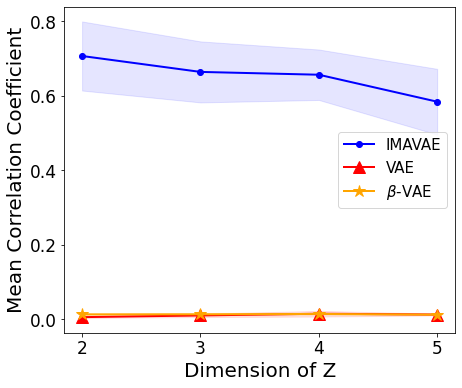

In [6]:
mcc_metrics_imavae = np.array(mcc_metrics_imavae)
mcc_metrics_vae = np.array(mcc_metrics_vae)
mcc_metrics_beta_vae = np.array(mcc_metrics_beta_vae)

fig, ax = plt.subplots(1, 1, figsize=(7,6))
ax.plot(z_m_dims, np.mean(mcc_metrics_imavae,axis=0), color='blue', lw=2, marker='.', markersize=12, label='IMAVAE')
ax.plot(z_m_dims, np.mean(mcc_metrics_vae,axis=0), color='red', lw=2, marker='^', markersize=12, label='VAE')
ax.plot(z_m_dims, np.mean(mcc_metrics_beta_vae,axis=0), color='orange', lw=2, marker='*', markersize=12, label=r'$\beta$-VAE')
ax.fill_between(
    z_m_dims, 
    np.mean(mcc_metrics_imavae,axis=0)-np.std(mcc_metrics_imavae,axis=0), 
    np.mean(mcc_metrics_imavae,axis=0)+np.std(mcc_metrics_imavae,axis=0), 
    color='blue', alpha=0.1
)
ax.fill_between(
    z_m_dims, 
    np.mean(mcc_metrics_vae,axis=0)-np.std(mcc_metrics_vae,axis=0), 
    np.mean(mcc_metrics_vae,axis=0)+np.std(mcc_metrics_vae,axis=0), 
    color='red', alpha=0.1
)
ax.fill_between(
    z_m_dims, 
    np.mean(mcc_metrics_beta_vae,axis=0)-np.std(mcc_metrics_beta_vae,axis=0), 
    np.mean(mcc_metrics_beta_vae,axis=0)+np.std(mcc_metrics_beta_vae,axis=0), 
    color='orange', alpha=0.1
)
ax.locator_params(nbins=4, axis='x')
ax.locator_params(nbins=5, axis='y')
ax.tick_params(axis='both', which='major', labelsize=17)
ax.set_xlabel('Dimension of Z', fontsize=20)
ax.set_ylabel('Mean Correlation Coefficient', fontsize=20)
ax.legend(prop={'size': 15})
plt.savefig('./Figures/mcc_varying_dz.png', dpi=600)

## Fit IMAVAE on the data with different number of training epochs and $d_Z = 2$

In [7]:
num_runs = 5
z_m_dim = 2
mcc_metrics_imavae = []
num_epochs = [5,10,20,40,60]

for i in range(num_runs):
    print(f"Run {i+1} \n=========================================")
    mcc_metric = []
    for idx, epochs in enumerate(num_epochs):
        T, X, Z = data[z_m_dim]['T'], data[z_m_dim]['X'], data[z_m_dim]['Z'], 
        Y, W = data[z_m_dim]['Y'], data[z_m_dim]['W']
        imavae = IMAVAE(n_components=z_m_dim, n_sup_networks=z_m_dim, n_hidden_layers=2, hidden_dim=25, 
                       optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1., anneal=False)
        WT = np.concatenate([T,W], axis=1)
        _ = imavae.fit(
            X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
            lr=1e-5, n_epochs=epochs, pretrain=False, verbose=1
        )
        with torch.no_grad():
            t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
            t0, t1 = torch.cat([t0, torch.tensor(W).float()], dim=1), torch.cat([t1, torch.tensor(W).float()], dim=1)
            z_m0_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
            z_m1_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
            # Estimated z_m for factual outcomes
            z_m_pred = torch.stack([z_m0_pred[i,:] if T[i,0] == 0 else z_m1_pred[i,:] for i in range(N)])
        mcc_metric.append(mcc(Z, z_m_pred.numpy()))
    mcc_metrics_imavae.append(mcc_metric)

Run 1 
Beginning Training


Epoch: 4, Best Epoch: 2, Best Recon MSE: 0.345172, Best Pred Metric [2.3089097, 


Saving the last epoch with training MSE: 0.218615 and Pred Metric: [6.2229295, 6.2229295]
Loaded the best model from Epoch: 2 with MSE: 0.345172 and Pred Metric: [2.3089097, 2.3089097]
Beginning Training


Epoch: 9, Best Epoch: 2, Best Recon MSE: 0.330879, Best Pred Metric [2.7351036, 


Saving the last epoch with training MSE: 0.143301 and Pred Metric: [3.2706132, 3.2706132]
Loaded the best model from Epoch: 2 with MSE: 0.330879 and Pred Metric: [2.7351036, 2.7351036]
Beginning Training


Epoch: 19, Best Epoch: 3, Best Recon MSE: 0.356068, Best Pred Metric [1.6918274,


Saving the last epoch with training MSE: 0.119571 and Pred Metric: [2.2521558, 2.2521558]
Loaded the best model from Epoch: 3 with MSE: 0.356068 and Pred Metric: [1.6918274, 1.6918274]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.107555, Best Pred Metric [0.3216842


Saving the last epoch with training MSE: 0.107555 and Pred Metric: [0.3216842, 0.3216842]
Loaded the best model from Epoch: 39 with MSE: 0.107555 and Pred Metric: [0.3216842, 0.3216842]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.106511, Best Pred Metric [0.1411141


Saving the last epoch with training MSE: 0.106511 and Pred Metric: [0.1411141, 0.1411141]
Loaded the best model from Epoch: 59 with MSE: 0.106511 and Pred Metric: [0.1411141, 0.1411141]
Run 2 
Beginning Training


Epoch: 4, Best Epoch: 3, Best Recon MSE: 0.327934, Best Pred Metric [2.28452, 2.


Saving the last epoch with training MSE: 0.26786 and Pred Metric: [4.3353524, 4.3353524]
Loaded the best model from Epoch: 3 with MSE: 0.327934 and Pred Metric: [2.28452, 2.28452]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.140749, Best Pred Metric [7.224331, 7


Saving the last epoch with training MSE: 0.140749 and Pred Metric: [7.224331, 7.224331]
Loaded the best model from Epoch: 9 with MSE: 0.140749 and Pred Metric: [7.224331, 7.224331]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.120893, Best Pred Metric [3.1386514


Saving the last epoch with training MSE: 0.120893 and Pred Metric: [3.1386514, 3.1386514]
Loaded the best model from Epoch: 19 with MSE: 0.120893 and Pred Metric: [3.1386514, 3.1386514]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.12322, Best Pred Metric [2.3535244,


Saving the last epoch with training MSE: 0.12322 and Pred Metric: [2.3535244, 2.3535244]
Loaded the best model from Epoch: 39 with MSE: 0.12322 and Pred Metric: [2.3535244, 2.3535244]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.10501, Best Pred Metric [0.33572462


Saving the last epoch with training MSE: 0.10501 and Pred Metric: [0.33572462, 0.33572462]
Loaded the best model from Epoch: 59 with MSE: 0.10501 and Pred Metric: [0.33572462, 0.33572462]
Run 3 
Beginning Training


Epoch: 4, Best Epoch: 1, Best Recon MSE: 0.404819, Best Pred Metric [8.065726, 8


Saving the last epoch with training MSE: 0.222868 and Pred Metric: [8.696706, 8.696706]
Loaded the best model from Epoch: 1 with MSE: 0.404819 and Pred Metric: [8.065726, 8.065726]
Beginning Training


Epoch: 9, Best Epoch: 3, Best Recon MSE: 0.344331, Best Pred Metric [3.5363822, 


Saving the last epoch with training MSE: 0.138103 and Pred Metric: [6.327371, 6.327371]
Loaded the best model from Epoch: 3 with MSE: 0.344331 and Pred Metric: [3.5363822, 3.5363822]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.113101, Best Pred Metric [1.4434856


Saving the last epoch with training MSE: 0.113101 and Pred Metric: [1.4434856, 1.4434856]
Loaded the best model from Epoch: 19 with MSE: 0.113101 and Pred Metric: [1.4434856, 1.4434856]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.108783, Best Pred Metric [0.3924499


Saving the last epoch with training MSE: 0.108783 and Pred Metric: [0.39244995, 0.39244995]
Loaded the best model from Epoch: 39 with MSE: 0.108783 and Pred Metric: [0.39244995, 0.39244995]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.107747, Best Pred Metric [0.1604380


Saving the last epoch with training MSE: 0.107747 and Pred Metric: [0.16043802, 0.16043802]
Loaded the best model from Epoch: 59 with MSE: 0.107747 and Pred Metric: [0.16043802, 0.16043802]
Run 4 
Beginning Training


Epoch: 4, Best Epoch: 2, Best Recon MSE: 0.313829, Best Pred Metric [8.419183, 8


Saving the last epoch with training MSE: 0.18909 and Pred Metric: [10.909192, 10.909192]
Loaded the best model from Epoch: 2 with MSE: 0.313829 and Pred Metric: [8.419183, 8.419183]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.13192, Best Pred Metric [4.9437237, 4


Saving the last epoch with training MSE: 0.13192 and Pred Metric: [4.9437237, 4.9437237]
Loaded the best model from Epoch: 9 with MSE: 0.13192 and Pred Metric: [4.9437237, 4.9437237]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.115245, Best Pred Metric [2.0488148


Saving the last epoch with training MSE: 0.115245 and Pred Metric: [2.0488148, 2.0488148]
Loaded the best model from Epoch: 19 with MSE: 0.115245 and Pred Metric: [2.0488148, 2.0488148]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.115056, Best Pred Metric [1.0659802


Saving the last epoch with training MSE: 0.115056 and Pred Metric: [1.0659802, 1.0659802]
Loaded the best model from Epoch: 39 with MSE: 0.115056 and Pred Metric: [1.0659802, 1.0659802]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.106248, Best Pred Metric [0.2374092


Saving the last epoch with training MSE: 0.106248 and Pred Metric: [0.2374092, 0.2374092]
Loaded the best model from Epoch: 59 with MSE: 0.106248 and Pred Metric: [0.2374092, 0.2374092]
Run 5 
Beginning Training


Epoch: 4, Best Epoch: 2, Best Recon MSE: 0.36988, Best Pred Metric [5.742457, 5.


Saving the last epoch with training MSE: 0.23758 and Pred Metric: [6.9800663, 6.9800663]
Loaded the best model from Epoch: 2 with MSE: 0.36988 and Pred Metric: [5.742457, 5.742457]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.212069, Best Pred Metric [5.904693, 5


Saving the last epoch with training MSE: 0.212069 and Pred Metric: [5.904693, 5.904693]
Loaded the best model from Epoch: 9 with MSE: 0.212069 and Pred Metric: [5.904693, 5.904693]
Beginning Training


Epoch: 19, Best Epoch: 6, Best Recon MSE: 0.336706, Best Pred Metric [4.3765883,


Saving the last epoch with training MSE: 0.134207 and Pred Metric: [6.660725, 6.660725]
Loaded the best model from Epoch: 6 with MSE: 0.336706 and Pred Metric: [4.3765883, 4.3765883]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.109479, Best Pred Metric [1.5265329


Saving the last epoch with training MSE: 0.109479 and Pred Metric: [1.5265329, 1.5265329]
Loaded the best model from Epoch: 39 with MSE: 0.109479 and Pred Metric: [1.5265329, 1.5265329]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.108531, Best Pred Metric [0.1441430

Saving the last epoch with training MSE: 0.108531 and Pred Metric: [0.14414304, 0.14414304]
Loaded the best model from Epoch: 59 with MSE: 0.108531 and Pred Metric: [0.14414304, 0.14414304]


## Fit regular VAE and $\beta$-VAE with different number of training epochs and $d_Z = 2$

In [8]:
# VAE
num_runs = 5
z_m_dim = 2
mcc_metrics_vae = []
num_epochs = [5,10,20,40,60]

for i in range(num_runs):
    print(f"Run {i+1} \n=========================================")
    mcc_metric = []
    for idx, epochs in enumerate(num_epochs):
        T, X, Z = data[z_m_dim]['T'], data[z_m_dim]['X'], data[z_m_dim]['Z'], 
        Y, W = data[z_m_dim]['Y'], data[z_m_dim]['W']
        imavae = IMAVAE(n_components=z_m_dim, n_sup_networks=z_m_dim, n_hidden_layers=2, hidden_dim=25, 
                        optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1., 
                        identifiable=False, prior_scale=0.01, anneal=False)
        WT = np.concatenate([T,W], axis=1)
        _ = imavae.fit(
            X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
            lr=1e-5, n_epochs=epochs, pretrain=False, verbose=1
        )
        with torch.no_grad():
            t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
            t0, t1 = torch.cat([t0, torch.tensor(W).float()], dim=1), torch.cat([t1, torch.tensor(W).float()], dim=1)
            z_m0_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            z_m1_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            # Estimated z_m for factual outcomes
            z_m_pred = torch.stack([z_m0_pred[i,:] if T[i,0] == 0 else z_m1_pred[i,:] for i in range(N)])
        mcc_metric.append(mcc(Z, z_m_pred.numpy()))
    mcc_metrics_vae.append(mcc_metric)

Run 1 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.872311, Best Pred Metric [2.8776338, 


Saving the last epoch with training MSE: 0.872311 and Pred Metric: [2.8776338, 2.8776338]
Loaded the best model from Epoch: 4 with MSE: 0.872311 and Pred Metric: [2.8776338, 2.8776338]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.365356, Best Pred Metric [1.1253715, 


Saving the last epoch with training MSE: 0.365356 and Pred Metric: [1.1253715, 1.1253715]
Loaded the best model from Epoch: 9 with MSE: 0.365356 and Pred Metric: [1.1253715, 1.1253715]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.158422, Best Pred Metric [3.0361817


Saving the last epoch with training MSE: 0.158422 and Pred Metric: [3.0361817, 3.0361817]
Loaded the best model from Epoch: 19 with MSE: 0.158422 and Pred Metric: [3.0361817, 3.0361817]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.125725, Best Pred Metric [0.8301663


Saving the last epoch with training MSE: 0.125725 and Pred Metric: [0.8301663, 0.8301663]
Loaded the best model from Epoch: 39 with MSE: 0.125725 and Pred Metric: [0.8301663, 0.8301663]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.124357, Best Pred Metric [0.2941624


Saving the last epoch with training MSE: 0.124357 and Pred Metric: [0.29416242, 0.29416242]
Loaded the best model from Epoch: 59 with MSE: 0.124357 and Pred Metric: [0.29416242, 0.29416242]
Run 2 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.895213, Best Pred Metric [11.0318985,


Saving the last epoch with training MSE: 0.895213 and Pred Metric: [11.0318985, 11.0318985]
Loaded the best model from Epoch: 4 with MSE: 0.895213 and Pred Metric: [11.0318985, 11.0318985]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.371362, Best Pred Metric [5.605875, 5


Saving the last epoch with training MSE: 0.371362 and Pred Metric: [5.605875, 5.605875]
Loaded the best model from Epoch: 9 with MSE: 0.371362 and Pred Metric: [5.605875, 5.605875]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.208317, Best Pred Metric [2.1391933


Saving the last epoch with training MSE: 0.208317 and Pred Metric: [2.1391933, 2.1391933]
Loaded the best model from Epoch: 19 with MSE: 0.208317 and Pred Metric: [2.1391933, 2.1391933]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.15647, Best Pred Metric [0.36577913


Saving the last epoch with training MSE: 0.15647 and Pred Metric: [0.36577913, 0.36577913]
Loaded the best model from Epoch: 39 with MSE: 0.15647 and Pred Metric: [0.36577913, 0.36577913]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.115275, Best Pred Metric [0.2436290


Saving the last epoch with training MSE: 0.115275 and Pred Metric: [0.24362902, 0.24362902]
Loaded the best model from Epoch: 59 with MSE: 0.115275 and Pred Metric: [0.24362902, 0.24362902]
Run 3 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.49115, Best Pred Metric [13.28558, 13


Saving the last epoch with training MSE: 0.49115 and Pred Metric: [13.28558, 13.28558]
Loaded the best model from Epoch: 4 with MSE: 0.49115 and Pred Metric: [13.28558, 13.28558]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.340141, Best Pred Metric [11.351955, 


Saving the last epoch with training MSE: 0.340141 and Pred Metric: [11.351955, 11.351955]
Loaded the best model from Epoch: 9 with MSE: 0.340141 and Pred Metric: [11.351955, 11.351955]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.197681, Best Pred Metric [0.5947509


Saving the last epoch with training MSE: 0.197681 and Pred Metric: [0.5947509, 0.5947509]
Loaded the best model from Epoch: 19 with MSE: 0.197681 and Pred Metric: [0.5947509, 0.5947509]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.125713, Best Pred Metric [1.6599469


Saving the last epoch with training MSE: 0.125713 and Pred Metric: [1.6599469, 1.6599469]
Loaded the best model from Epoch: 39 with MSE: 0.125713 and Pred Metric: [1.6599469, 1.6599469]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.113738, Best Pred Metric [0.1699256


Saving the last epoch with training MSE: 0.113738 and Pred Metric: [0.1699256, 0.1699256]
Loaded the best model from Epoch: 59 with MSE: 0.113738 and Pred Metric: [0.1699256, 0.1699256]
Run 4 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.920067, Best Pred Metric [13.499884, 


Saving the last epoch with training MSE: 0.920067 and Pred Metric: [13.499884, 13.499884]
Loaded the best model from Epoch: 4 with MSE: 0.920067 and Pred Metric: [13.499884, 13.499884]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.362638, Best Pred Metric [4.6259475, 


Saving the last epoch with training MSE: 0.362638 and Pred Metric: [4.6259475, 4.6259475]
Loaded the best model from Epoch: 9 with MSE: 0.362638 and Pred Metric: [4.6259475, 4.6259475]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.187996, Best Pred Metric [1.3980647


Saving the last epoch with training MSE: 0.187996 and Pred Metric: [1.3980647, 1.3980647]
Loaded the best model from Epoch: 19 with MSE: 0.187996 and Pred Metric: [1.3980647, 1.3980647]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.122707, Best Pred Metric [2.3542068


Saving the last epoch with training MSE: 0.122707 and Pred Metric: [2.3542068, 2.3542068]
Loaded the best model from Epoch: 39 with MSE: 0.122707 and Pred Metric: [2.3542068, 2.3542068]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.115142, Best Pred Metric [0.4206919


Saving the last epoch with training MSE: 0.115142 and Pred Metric: [0.42069197, 0.42069197]
Loaded the best model from Epoch: 59 with MSE: 0.115142 and Pred Metric: [0.42069197, 0.42069197]
Run 5 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.609539, Best Pred Metric [4.3172545, 


Saving the last epoch with training MSE: 0.609539 and Pred Metric: [4.3172545, 4.3172545]
Loaded the best model from Epoch: 4 with MSE: 0.609539 and Pred Metric: [4.3172545, 4.3172545]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.361996, Best Pred Metric [4.324845, 4


Saving the last epoch with training MSE: 0.361996 and Pred Metric: [4.324845, 4.324845]
Loaded the best model from Epoch: 9 with MSE: 0.361996 and Pred Metric: [4.324845, 4.324845]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.182468, Best Pred Metric [2.726699,


Saving the last epoch with training MSE: 0.182468 and Pred Metric: [2.726699, 2.726699]
Loaded the best model from Epoch: 19 with MSE: 0.182468 and Pred Metric: [2.726699, 2.726699]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.147942, Best Pred Metric [0.6060753


Saving the last epoch with training MSE: 0.147942 and Pred Metric: [0.60607535, 0.60607535]
Loaded the best model from Epoch: 39 with MSE: 0.147942 and Pred Metric: [0.60607535, 0.60607535]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.114224, Best Pred Metric [0.8000781

Saving the last epoch with training MSE: 0.114224 and Pred Metric: [0.80007815, 0.80007815]
Loaded the best model from Epoch: 59 with MSE: 0.114224 and Pred Metric: [0.80007815, 0.80007815]


In [9]:
# beta-VAE
num_runs = 5
z_m_dim = 2
mcc_metrics_beta_vae = []
num_epochs = [5,10,20,40,60]

for i in range(num_runs):
    print(f"Run {i+1} \n=========================================")
    mcc_metric = []
    for idx, epochs in enumerate(num_epochs):
        T, X, Z = data[z_m_dim]['T'], data[z_m_dim]['X'], data[z_m_dim]['Z'], 
        Y, W = data[z_m_dim]['Y'], data[z_m_dim]['W']
        imavae = IMAVAE(n_components=z_m_dim, n_sup_networks=z_m_dim, n_hidden_layers=2, hidden_dim=25, 
                        optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1., 
                        identifiable=False, beta=4.0, prior_scale=0.01, anneal=False)
        WT = np.concatenate([T,W], axis=1)
        _ = imavae.fit(
            X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
            lr=1e-5, n_epochs=epochs, pretrain=False, verbose=1
        )
        with torch.no_grad():
            t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
            t0, t1 = torch.cat([t0, torch.tensor(W).float()], dim=1), torch.cat([t1, torch.tensor(W).float()], dim=1)
            z_m0_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            z_m1_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            # Estimated z_m for factual outcomes
            z_m_pred = torch.stack([z_m0_pred[i,:] if T[i,0] == 0 else z_m1_pred[i,:] for i in range(N)])
        mcc_metric.append(mcc(Z, z_m_pred.numpy()))
    mcc_metrics_beta_vae.append(mcc_metric)

Run 1 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.999961, Best Pred Metric [4.353947, 4


Saving the last epoch with training MSE: 0.999961 and Pred Metric: [4.353947, 4.353947]
Loaded the best model from Epoch: 4 with MSE: 0.999961 and Pred Metric: [4.353947, 4.353947]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.998442, Best Pred Metric [5.6870494, 


Saving the last epoch with training MSE: 0.998442 and Pred Metric: [5.6870494, 5.6870494]
Loaded the best model from Epoch: 9 with MSE: 0.998442 and Pred Metric: [5.6870494, 5.6870494]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.997534, Best Pred Metric [1.512909,


Saving the last epoch with training MSE: 0.997534 and Pred Metric: [1.512909, 1.512909]
Loaded the best model from Epoch: 19 with MSE: 0.997534 and Pred Metric: [1.512909, 1.512909]
Beginning Training


Epoch: 39, Best Epoch: 38, Best Recon MSE: 0.190359, Best Pred Metric [0.4155896


Saving the last epoch with training MSE: 0.192369 and Pred Metric: [0.42521998, 0.42521998]
Loaded the best model from Epoch: 38 with MSE: 0.190359 and Pred Metric: [0.41558963, 0.41558963]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.127101, Best Pred Metric [0.1970258


Saving the last epoch with training MSE: 0.127101 and Pred Metric: [0.19702584, 0.19702584]
Loaded the best model from Epoch: 59 with MSE: 0.127101 and Pred Metric: [0.19702584, 0.19702584]
Run 2 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.993317, Best Pred Metric [10.411683, 


Saving the last epoch with training MSE: 0.993317 and Pred Metric: [10.411683, 10.411683]
Loaded the best model from Epoch: 4 with MSE: 0.993317 and Pred Metric: [10.411683, 10.411683]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.891248, Best Pred Metric [4.40108, 4.


Saving the last epoch with training MSE: 0.891248 and Pred Metric: [4.40108, 4.40108]
Loaded the best model from Epoch: 9 with MSE: 0.891248 and Pred Metric: [4.40108, 4.40108]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.370451, Best Pred Metric [5.094436,


Saving the last epoch with training MSE: 0.370451 and Pred Metric: [5.094436, 5.094436]
Loaded the best model from Epoch: 19 with MSE: 0.370451 and Pred Metric: [5.094436, 5.094436]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.210856, Best Pred Metric [0.6446602


Saving the last epoch with training MSE: 0.210856 and Pred Metric: [0.6446602, 0.6446602]
Loaded the best model from Epoch: 39 with MSE: 0.210856 and Pred Metric: [0.6446602, 0.6446602]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.145923, Best Pred Metric [0.2243277


Saving the last epoch with training MSE: 0.145923 and Pred Metric: [0.22432777, 0.22432777]
Loaded the best model from Epoch: 59 with MSE: 0.145923 and Pred Metric: [0.22432777, 0.22432777]
Run 3 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 1.00041, Best Pred Metric [10.298789, 1


Saving the last epoch with training MSE: 1.00041 and Pred Metric: [10.298789, 10.298789]
Loaded the best model from Epoch: 4 with MSE: 1.00041 and Pred Metric: [10.298789, 10.298789]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.999447, Best Pred Metric [2.0968122, 


Saving the last epoch with training MSE: 0.999447 and Pred Metric: [2.0968122, 2.0968122]
Loaded the best model from Epoch: 9 with MSE: 0.999447 and Pred Metric: [2.0968122, 2.0968122]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.36231, Best Pred Metric [2.1734202,


Saving the last epoch with training MSE: 0.36231 and Pred Metric: [2.1734202, 2.1734202]
Loaded the best model from Epoch: 19 with MSE: 0.36231 and Pred Metric: [2.1734202, 2.1734202]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.294673, Best Pred Metric [0.7267722


Saving the last epoch with training MSE: 0.294673 and Pred Metric: [0.7267722, 0.7267722]
Loaded the best model from Epoch: 39 with MSE: 0.294673 and Pred Metric: [0.7267722, 0.7267722]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.13734, Best Pred Metric [0.69007355


Saving the last epoch with training MSE: 0.13734 and Pred Metric: [0.69007355, 0.69007355]
Loaded the best model from Epoch: 59 with MSE: 0.13734 and Pred Metric: [0.69007355, 0.69007355]
Run 4 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 1.00013, Best Pred Metric [9.76992, 9.7


Saving the last epoch with training MSE: 1.00013 and Pred Metric: [9.76992, 9.76992]
Loaded the best model from Epoch: 4 with MSE: 1.00013 and Pred Metric: [9.76992, 9.76992]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.998594, Best Pred Metric [8.09473, 8.


Saving the last epoch with training MSE: 0.998594 and Pred Metric: [8.09473, 8.09473]
Loaded the best model from Epoch: 9 with MSE: 0.998594 and Pred Metric: [8.09473, 8.09473]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.367543, Best Pred Metric [2.8050125


Saving the last epoch with training MSE: 0.367543 and Pred Metric: [2.8050125, 2.8050125]
Loaded the best model from Epoch: 19 with MSE: 0.367543 and Pred Metric: [2.8050125, 2.8050125]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.265058, Best Pred Metric [0.5876202


Saving the last epoch with training MSE: 0.265058 and Pred Metric: [0.58762026, 0.58762026]
Loaded the best model from Epoch: 39 with MSE: 0.265058 and Pred Metric: [0.58762026, 0.58762026]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.128259, Best Pred Metric [0.2694014


Saving the last epoch with training MSE: 0.128259 and Pred Metric: [0.2694014, 0.2694014]
Loaded the best model from Epoch: 59 with MSE: 0.128259 and Pred Metric: [0.2694014, 0.2694014]
Run 5 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.998065, Best Pred Metric [8.218791, 8


Saving the last epoch with training MSE: 0.998065 and Pred Metric: [8.218791, 8.218791]
Loaded the best model from Epoch: 4 with MSE: 0.998065 and Pred Metric: [8.218791, 8.218791]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.996171, Best Pred Metric [7.829873, 7


Saving the last epoch with training MSE: 0.996171 and Pred Metric: [7.829873, 7.829873]
Loaded the best model from Epoch: 9 with MSE: 0.996171 and Pred Metric: [7.829873, 7.829873]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.369814, Best Pred Metric [2.608542,


Saving the last epoch with training MSE: 0.369814 and Pred Metric: [2.608542, 2.608542]
Loaded the best model from Epoch: 19 with MSE: 0.369814 and Pred Metric: [2.608542, 2.608542]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.183446, Best Pred Metric [0.4143953


Saving the last epoch with training MSE: 0.183446 and Pred Metric: [0.41439533, 0.41439533]
Loaded the best model from Epoch: 39 with MSE: 0.183446 and Pred Metric: [0.41439533, 0.41439533]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.135535, Best Pred Metric [0.2174168

Saving the last epoch with training MSE: 0.135535 and Pred Metric: [0.21741681, 0.21741681]
Loaded the best model from Epoch: 59 with MSE: 0.135535 and Pred Metric: [0.21741681, 0.21741681]


## Compare mean correlation coefficients for varying number of training epochs

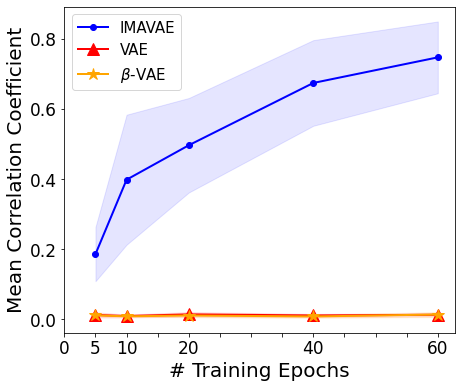

In [16]:
mcc_metrics_imavae = np.array(mcc_metrics_imavae)
mcc_metrics_vae = np.array(mcc_metrics_vae)
mcc_metrics_beta_vae = np.array(mcc_metrics_beta_vae)

fig, ax = plt.subplots(1, 1, figsize=(7,6))
ax.plot(num_epochs, np.mean(mcc_metrics_imavae,axis=0), color='blue', lw=2, marker='.', markersize=12, label='IMAVAE')
ax.plot(num_epochs, np.mean(mcc_metrics_vae,axis=0), color='red', lw=2, marker='^', markersize=12, label='VAE')
ax.plot(num_epochs, np.mean(mcc_metrics_beta_vae,axis=0), color='orange', lw=2, marker='*', markersize=12, label=r'$\beta$-VAE')
ax.fill_between(
    num_epochs, 
    np.mean(mcc_metrics_imavae,axis=0)-np.std(mcc_metrics_imavae,axis=0), 
    np.mean(mcc_metrics_imavae,axis=0)+np.std(mcc_metrics_imavae,axis=0), 
    color='blue', alpha=0.1
)
ax.fill_between(
    num_epochs, 
    np.mean(mcc_metrics_vae,axis=0)-np.std(mcc_metrics_vae,axis=0), 
    np.mean(mcc_metrics_vae,axis=0)+np.std(mcc_metrics_vae,axis=0), 
    color='red', alpha=0.1
)
ax.fill_between(
    num_epochs, 
    np.mean(mcc_metrics_beta_vae,axis=0)-np.std(mcc_metrics_beta_vae,axis=0), 
    np.mean(mcc_metrics_beta_vae,axis=0)+np.std(mcc_metrics_beta_vae,axis=0), 
    color='orange', alpha=0.1
)
ax.set_xticks(np.linspace(0,60,13), ['0','5','10','','20','','','','40','','','','60'])
ax.locator_params(nbins=5, axis='y')
ax.tick_params(axis='both', which='major', labelsize=17)
ax.set_xlabel('# Training Epochs', fontsize=20)
ax.set_ylabel('Mean Correlation Coefficient', fontsize=20)
ax.legend(prop={'size': 15})
plt.savefig('./Figures/mcc_varying_epochs.png', dpi=600)